In [1]:
import pandas as pd
from patsy import dmatrix

METRIC = 'ndcg_at_10'
DOWNSAMPLE_TO = 1000
METRIC_ALIAS = METRIC.replace('_at_', '@').upper()

# read dataframe
df = pd.read_csv(f'../../data/{METRIC}.csv').rename({METRIC: METRIC_ALIAS}, axis=1)

# # downsample datasets
downsampled = []
for dataset in df['dataset'].drop_duplicates().tolist():
    group = df[df['dataset'] == dataset]
    queries = group['query_id'].drop_duplicates()
    if DOWNSAMPLE_TO and len(queries) > DOWNSAMPLE_TO:
        queries = queries.sample(n=DOWNSAMPLE_TO, random_state=42)
        group = group[group['query_id'].isin(queries)]
    downsampled.append(group)

df = pd.concat(downsampled).reset_index(drop=True)
df

,query_id,NDCG@10,model,context,interpolation,dataset
0,query_0,100.000000,e5-large-v2,512,linear,SFD
1,query_1,0.000000,e5-large-v2,512,linear,SFD
2,query_2,35.620719,e5-large-v2,512,linear,SFD
3,query_3,100.000000,e5-large-v2,512,linear,SFD
4,query_4,100.000000,e5-large-v2,512,linear,SFD
...,...,...,...,...,...,...
94891,query_10413,0.000000,snowflake-arctic-embed-l,3072,cubic,NQA
94892,query_10423,31.546488,snowflake-arctic-embed-l,3072,cubic,NQA
94893,query_10434,0.000000,snowflake-arctic-embed-l,3072,cubic,NQA
94894,query_10438,0.000000,snowflake-arctic-embed-l,3072,cubic,NQA


In [2]:
import pickle

import pandas as pd
import statsmodels.formula.api as smf

formula = "Q('NDCG@10') ~ C(interpolation, Treatment(reference='linear')) * C(context, Treatment(reference=512))"

md = smf.mixedlm(
    formula,
    df,
    groups=df['dataset'],  # top-level grouping by dataset
    re_formula='~1',
    vc_formula={
        'query_id': '0 + C(query_id)',
        'model': '0 + C(model)',
    }
)

mfit = md.fit(reml=True)
with open('lmm.pkl', 'wb') as f:
    pickle.dump(mfit, f)

print(mfit.summary())

                                                      Mixed Linear Model Regression Results
Model:                                         MixedLM                              Dependent Variable:                              Q('NDCG@10')
No. Observations:                              94896                                Method:                                          REML        
No. Groups:                                    4                                    Scale:                                           576.9270    
Min. group size:                               10800                                Log-Likelihood:                                  -440640.7288
Max. group size:                               36000                                Converged:                                       Yes         
Mean group size:                               23724.0                                                                                           
--------------------------------

In [3]:
mfit.pvalues < 0.05

Intercept                                                                                                 True
C(interpolation, Treatment(reference='linear'))[T.cubic]                                                 False
C(context, Treatment(reference=512))[T.1024]                                                              True
C(context, Treatment(reference=512))[T.1536]                                                              True
C(context, Treatment(reference=512))[T.2048]                                                              True
C(context, Treatment(reference=512))[T.2560]                                                             False
C(context, Treatment(reference=512))[T.3072]                                                              True
C(interpolation, Treatment(reference='linear'))[T.cubic]:C(context, Treatment(reference=512))[T.1024]    False
C(interpolation, Treatment(reference='linear'))[T.cubic]:C(context, Treatment(reference=512))[T.1536]     True
C

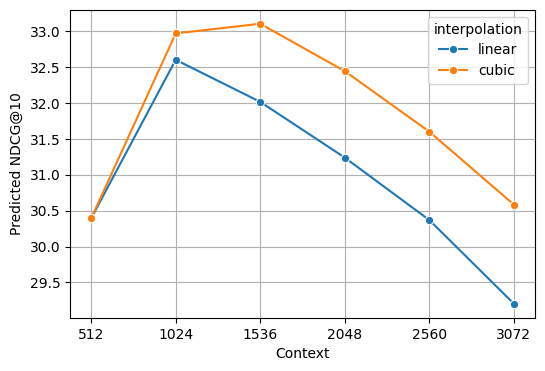

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

contexts = sorted(df['context'].unique())
interpolations = df['interpolation'].unique()
pred_df = pd.DataFrame([
    {'context': c, 'interpolation': i}
    for c in contexts
    for i in interpolations
])

# compute predicted NDCG@10
pred_df['predicted'] = mfit.predict(pred_df)

# plot
plt.figure(figsize=(6,4))
for interp in interpolations:
    sns.lineplot(
        x='context', y='predicted', marker='o',
        data=pred_df[pred_df['interpolation'] == interp],
        label=interp
    )

plt.xticks(contexts)
plt.xlabel('Context')
plt.ylabel('Predicted NDCG@10')
plt.legend(title='interpolation')
plt.grid(True)
plt.show()